# Amazon Reviews for Sentiment Analysis
This dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels) for learning how to train sentiment analysis.We have used this data in our research for Aspect Category Learning and Sentiment classification using rating

Connect to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all the required libraries

In [ ]:
import numpy as np
import pandas as pd
import bz2
import os
import seaborn as sns
from tqdm import tqdm
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import plotly.graph_objects as go
from wordcloud import WordCloud

import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import tensorflow as tf
from keras.models import load_model,Sequential,Model
from keras.layers import Dense, Activation,MaxPooling1D,Embedding, GlobalMaxPool1D,Attention,Input,Conv1D,Dropout,Layer,InputSpec,CuDNNLSTM
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,Bidirectional,concatenate,SpatialDropout1D,GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras import metrics
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import models
from tensorflow import keras

from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam,RMSprop

!pip install snorkel
from snorkel.labeling import labeling_function
import snorkel
from snorkel.labeling import labeling_function, PandasLFApplier,LFAnalysis
from snorkel.labeling.model import LabelModel,MajorityLabelVoter

!pip install scikit-multilearn
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss, accuracy_score,multilabel_confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix,classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


     |████████████████████████████████| 103 kB 5.4 MB/s 
     |████████████████████████████████| 5.6 MB 30.9 MB/s 
     |████████████████████████████████| 14.8 MB 391 kB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
ye

     |████████████████████████████████| 89 kB 3.8 MB/s 


Change the current path

In [ ]:
os.chdir("/content/drive/MyDrive/mid-thesis/amazon_review")

## Read the Train and Test Dataset

In [ ]:
data=bz2.BZ2File("train.ft.txt.bz2")

In [ ]:
data=data.readlines()

In [ ]:
data=[x.decode('utf-8') for x in data]

## Understand the Dataset

In [ ]:
len(data)

3600000

In [ ]:
data[1:50]

["__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n",
 '__label__2 Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Tri

## Data Pre-Processing

Split the data into labels and the review sentences

In [ ]:
labels=[0 if x.split(' ')[0]=="__label__1" else 1 for x in data][:500000]
review_original=[ x.split(' ',1)[1][:-1].lower() for x in data]
review_text=[ x.split(' ',1)[1][:-1].lower() for x in data]

Merge Review text and Rating as a single Dataframe

In [ ]:
data_zipped=pd.DataFrame(list(zip(labels,review_text)),columns=["Rating","Review_Text"])
data_zipped

,Rating,Review_Text
0,1,stuning even for the non-gamer: this sound tra...
1,1,the best soundtrack ever to anything.: i'm rea...
2,1,amazing!: this soundtrack is my favorite music...
3,1,excellent soundtrack: i truly like this soundt...
4,1,"remember, pull your jaw off the floor after he..."
...,...,...
499995,0,prepare for offence: ridley's conjecture and s...
499996,1,this is a great song but buy the album.: trust...
499997,0,what happen to fram gas filter's quality ???: ...
499998,0,no filter on 2003 hyundai xg350l!!!: there is ...


Filter the reviews related to the products which will remove reviews on book content,dvd contents like movies,shows and songs and selects reviews based on some of the products

In [ ]:
data_filtered = data_zipped[data_zipped['Review_Text'].str.contains('product')]

In [ ]:
data_filtered=data_filtered[~data_filtered['Review_Text'].str.contains('music|game|soundtrack|cd|song|book|album|story|film|dvd|disc|narrative|movie|track|henry|theatre|record|author|reading|writing|read|character|video|novel|travel|dishes|rap|beat|c.d.|essay|studio|watched|star|comedy|comedian|hollywood|thriller|audience|tv|series|economics|government|chapter|narrating|thomas|cast|script|stories|cinimatography|show|published|stream|reader|kindle|reading|drama|literary|adam|sandler|episodes|watch|recording|charlie brown|stars|charlie brown|show|watched|dialogue|act|voice|singer|band|microphone|bands|season|acted|artist|voice|listeners|lyrics|scene|hits|rockers|fantacy|news|plot|twist|intellectual|james brown|brown|narratione')]

In [ ]:
len(data_filtered)

15536

Around 500 data observations are tagged with Aspect Categories and Aspect Terms. Around 400 observations will be used for training and 100 for testing
Aspect_Sentiment is only labelled for test data

In [ ]:
tagged_data = pd.read_csv("amazon_tagged_data.csv",encoding = 'cp1252')

In [ ]:
tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment
0,1,"I am loving the size of this shirt ,fits me well",NaN,NaN,"size,fits",NaN,NaN,"size,fits,",POSITIVE
1,0,"The quality of this toy is very bad,it is broken",NaN,NaN,NaN,NaN,"quality,broken","quality,broken",NEGATIVE
2,0,"The manual instructions are very bad ,wish to ...",NaN,NaN,NaN,"manual,instructions,contact,seller",NaN,"manual,instructions,contact,seller",NEGATIVE
3,1,"The cost is very less for this chair ,only 10$",NaN,"cost,",NaN,NaN,NaN,"cost,$",POSITIVE
4,0,This chair is very useful and functions very well,"useful,functions",NaN,NaN,NaN,NaN,"useful,functions",MIXED


In [ ]:
len(tagged_data)

500

Remaining data will be used as unlabelled data

In [ ]:
unlabelled_data= data_filtered[1000:-1000]
len(unlabelled_data)

13536

Replace the null Values as "Not Found"

In [ ]:
tagged_data['Aspect_Terms']=tagged_data['Aspect_Terms'].str.replace("nan,","")
tagged_data['Aspect_Terms']=tagged_data['Aspect_Terms'].str.replace("nan","")

In [ ]:
for col in tagged_data.columns:
  tagged_data[col].fillna("NotFound",inplace=True)

In [ ]:
tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment
0,1,"I am loving the size of this shirt ,fits me well",NotFound,NotFound,"size,fits",NotFound,NotFound,"size,fits,",POSITIVE
1,0,"The quality of this toy is very bad,it is broken",NotFound,NotFound,NotFound,NotFound,"quality,broken","quality,broken",NEGATIVE
2,0,"The manual instructions are very bad ,wish to ...",NotFound,NotFound,NotFound,"manual,instructions,contact,seller",NotFound,"manual,instructions,contact,seller",NEGATIVE
3,1,"The cost is very less for this chair ,only 10$",NotFound,"cost,",NotFound,NotFound,NotFound,"cost,$",POSITIVE
4,0,This chair is very useful and functions very well,"useful,functions",NotFound,NotFound,NotFound,NotFound,"useful,functions",MIXED


## Extract the aspect terms which were manually labelled

In [ ]:
def remove_duplicate(x):
  return list(dict.fromkeys(x))

usability_aspect_terms=','.join([i.strip() for i in tagged_data['Usability'] if i != "NotFound"]).split(',')
usability_aspect_terms=remove_duplicate([x.strip() for x in usability_aspect_terms if x!=''])

price_aspect_terms=','.join([i.strip() for i in tagged_data['Price'] if i != "NotFound"]).split(',')
price_aspect_terms=remove_duplicate([x.strip() for x in price_aspect_terms if x!=''])

size_aspect_terms=','.join([i.strip() for i in tagged_data['Size'] if i != "NotFound"]).split(',')
size_aspect_terms=remove_duplicate([x.strip() for x in size_aspect_terms if x!=''])

service_aspect_terms=','.join([i.strip() for i in tagged_data['Service'] if i != "NotFound"]).split(',')
service_aspect_terms=remove_duplicate([x.strip() for x in service_aspect_terms if x!=''])

quality_Aspect_terms=','.join([i.strip() for i in tagged_data['Quality'] if i != "NotFound"]).split(',')
quality_Aspect_terms=remove_duplicate([x.strip() for x in quality_Aspect_terms if x!=''])


In [ ]:
usability_aspect_terms

['useful',
 'functions',
 'wear',
 'pulled',
 'workout',
 'roll down',
 'rolled up down',
 'flexibility',
 'using',
 'useless',
 'work',
 'making',
 'function',
 'holding',
 'playing',
 'comfy',
 'fun',
 'uncomfortable',
 'taste',
 'tastes',
 'performance',
 'use',
 'moves',
 'works',
 'learning tool',
 'stacking',
 'knocking',
 'playtime',
 'spin',
 'twirl',
 'educational',
 'worked',
 'rotate',
 'used',
 'played',
 'boring',
 'portable',
 'comfortable',
 'worn',
 'play',
 'assemble',
 'drag',
 'absorbs',
 'pull',
 'wearing',
 'pushed',
 'flexible',
 'roll up',
 'wore',
 'squeezed',
 'hold',
 'feel',
 'holds',
 'bruising',
 'pushing',
 'working',
 'push',
 'put it on',
 'pulling',
 'hurts',
 'lifting',
 'put on',
 'does the job',
 'felt',
 'burned',
 'eating',
 'attention',
 'user friendly',
 'feeding',
 'warming',
 'disassemble',
 'functional',
 'effective',
 'assembly',
 'easy to put',
 'assembled',
 'operated',
 'scrubbed',
 'roll over',
 'flickering',
 'stopped',
 'stayed',
 'usag

In [ ]:
price_aspect_terms

['cost',
 'price',
 'inexpensive',
 'investment',
 'money',
 'penny',
 'pay',
 'cheap',
 'spent',
 'pricy',
 'priced',
 'expensive',
 'cheaper',
 'costs',
 'cheapest',
 'free',
 'paid',
 'dollar',
 'overpriced',
 'bucks',
 'pricing',
 'budget',
 'tax',
 'Money',
 '0',
 'expense',
 'costly',
 'fee']

In [ ]:
size_aspect_terms

['size',
 'fits',
 'heavy',
 'sizes',
 'chart',
 'smaller',
 'large',
 'feet',
 'big',
 'fit',
 'longer',
 'small',
 'tiny',
 'width',
 'thin',
 'taller',
 'tight',
 'small inch',
 'skinny',
 'hefty',
 'long',
 'xl',
 'length',
 'ft',
 'inches',
 'measurement',
 'streched',
 'medium',
 'xlarge',
 'sized',
 'smaller size',
 'pound',
 'tall',
 'tightness',
 'bulky',
 'sizing',
 'measure',
 'shorter',
 'short',
 'tighter',
 'inch',
 'size chart',
 'xs',
 'high',
 'measured',
 'stouter',
 'wider',
 'x-large',
 'mediums',
 'bigger',
 'foot',
 'lower',
 'height',
 'lowering',
 'fitted',
 'higher',
 'lowered',
 'larger']

In [ ]:
service_aspect_terms

['manual',
 'instructions',
 'contact',
 'seller',
 'shipping',
 'return',
 'arrived',
 'cardboard box',
 'box',
 'packaging',
 'packaged',
 'date',
 'contacted',
 'response',
 'refund',
 'apologized',
 'trust',
 'duplicate',
 'delivered',
 'advertisement',
 'instructional',
 'description',
 'policy',
 'unprofessional',
 'advertised',
 'pollicies',
 'replied',
 'fake',
 'company',
 'missing',
 'production',
 'consumers',
 'waiting',
 'warranty',
 'email',
 'advertising',
 'shipped',
 'misleading',
 'packed',
 'customer',
 'service',
 'replacing',
 'returns',
 'sent back',
 'advertized',
 'exchange',
 'package',
 'ship',
 'advertises',
 'comply',
 'contacting',
 'respond',
 'delivery',
 'dellivery',
 'warn',
 'described',
 'details',
 'miswire',
 'manufacturer',
 'tech staff',
 'mentioned',
 'lack',
 'faulty',
 'arrive',
 'repairable',
 'emails',
 'calls',
 'companies',
 'reply',
 'inquiries',
 'customer service',
 'receipt',
 'customers',
 'manufacture',
 'manufacturers',
 'apology',
 

In [ ]:
quality_Aspect_terms

['quality',
 'broken',
 'tore',
 'lasts',
 'inferior',
 'solid',
 'brass',
 'scraped',
 'smells',
 'delicate',
 'plastic',
 'stiff',
 'tolerate',
 'textured',
 'chinsy',
 'blunt',
 'sharp edges',
 'sharp',
 'waterproof',
 'soft',
 'smell',
 'smooths',
 'broke',
 'poor',
 'textureline',
 'fabric',
 'scratched',
 'metal',
 'smooth',
 'damage',
 'poorly',
 'flimsy',
 'weak',
 'blur',
 'stainless steel',
 'rubbery',
 'rubber',
 'material',
 'sturdy',
 'repair',
 'defective',
 'wrinkles',
 'smelled',
 'described',
 'last longer',
 'mark',
 'uneffected',
 'undamaged',
 'strong',
 'durable',
 'thick',
 'poorest',
 'damaged',
 'break',
 'thicker',
 'reliable',
 'low-grade',
 'tarnish',
 'breaks',
 'lasted',
 'leather',
 'conductive',
 'steady',
 'latex',
 'sleek',
 'weaker',
 'melted',
 'steel',
 'came off',
 'quallity',
 'cotton',
 'overheating',
 'lather',
 'rusted',
 'durability',
 'poor quality',
 'materials',
 'rubberized',
 'lasting']

Create the Aspect_Category column for the tagged data having all the categories as a string which will be used for comparision with the predict labels

In [ ]:
aspects=[]
for i in range(0,len(tagged_data)):
  aspect_values=[]
  invalid_data=0
  for col in ['Usability','Price','Size','Service','Quality']:
    if tagged_data.loc[i,col] != "NotFound":
      aspect_values.append(col)
      invalid_data+=1
  if(invalid_data==0):
    print("the row %d is bad data",i)
  else:
    aspect_values.sort()
    asp=','.join(aspect_values)
    aspects.append(asp)
print(aspects)
tagged_data['Aspect_Category']=aspects

['Size', 'Quality', 'Service', 'Price', 'Usability', 'Quality,Size', 'Service,Size,Usability', 'Price,Usability', 'Price,Quality,Service,Size', 'Price,Quality,Size', 'Price,Usability', 'Usability', 'Size', 'Price,Quality,Usability', 'Size,Usability', 'Size,Usability', 'Service,Usability', 'Quality', 'Usability', 'Usability', 'Usability', 'Service,Size', 'Quality', 'Price,Quality,Service', 'Quality,Service,Size', 'Usability', 'Usability', 'Quality', 'Quality', 'Size,Usability', 'Price,Service', 'Service', 'Quality,Service', 'Usability', 'Quality,Size,Usability', 'Service,Size', 'Usability', 'Service', 'Size,Usability', 'Usability', 'Price,Usability', 'Size', 'Service', 'Service', 'Service', 'Quality,Service', 'Usability', 'Quality,Usability', 'Usability', 'Price,Usability', 'Quality,Usability', 'Price,Usability', 'Quality', 'Quality,Usability', 'Usability', 'Price,Service', 'Price', 'Price,Quality,Size,Usability', 'Price,Quality', 'Quality,Usability', 'Size,Usability', 'Size,Usability',

In [ ]:
tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category
0,1,"I am loving the size of this shirt ,fits me well",NotFound,NotFound,"size,fits",NotFound,NotFound,"size,fits,",POSITIVE,Size
1,0,"The quality of this toy is very bad,it is broken",NotFound,NotFound,NotFound,NotFound,"quality,broken","quality,broken",NEGATIVE,Quality
2,0,"The manual instructions are very bad ,wish to ...",NotFound,NotFound,NotFound,"manual,instructions,contact,seller",NotFound,"manual,instructions,contact,seller",NEGATIVE,Service
3,1,"The cost is very less for this chair ,only 10$",NotFound,"cost,",NotFound,NotFound,NotFound,"cost,$",POSITIVE,Price
4,0,This chair is very useful and functions very well,"useful,functions",NotFound,NotFound,NotFound,NotFound,"useful,functions",MIXED,Usability


## Split the tagged data into train and test

Tagged train data

In [ ]:
train_tagged_data = tagged_data[:400]
len(train_tagged_data)

400

In [ ]:
train_tagged_data.head()


,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category
0,1,"I am loving the size of this shirt ,fits me well",NotFound,NotFound,"size,fits",NotFound,NotFound,"size,fits,",POSITIVE,Size
1,0,"The quality of this toy is very bad,it is broken",NotFound,NotFound,NotFound,NotFound,"quality,broken","quality,broken",NEGATIVE,Quality
2,0,"The manual instructions are very bad ,wish to ...",NotFound,NotFound,NotFound,"manual,instructions,contact,seller",NotFound,"manual,instructions,contact,seller",NEGATIVE,Service
3,1,"The cost is very less for this chair ,only 10$",NotFound,"cost,",NotFound,NotFound,NotFound,"cost,$",POSITIVE,Price
4,0,This chair is very useful and functions very well,"useful,functions",NotFound,NotFound,NotFound,NotFound,"useful,functions",MIXED,Usability


Tagged Test Data

In [ ]:
test_tagged_data = tagged_data[400:500]
len(test_tagged_data)

100

In [ ]:
test_tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category
400,0,exercise outside: it was my mistake. i didn't ...,NotFound,NotFound,fit,"return,packing",NotFound,"fit,return,packing",NEGATIVE,"Service,Size"
401,1,very comfortable: it was a little difficult to...,comfortable,NotFound,sizing,NotFound,cotton,"comfortable,sizing,cotton",MIXED,"Quality,Size,Usability"
402,1,a little bit big..: i love soffe shorts and we...,wear,NotFound,"big,bigger,size",NotFound,NotFound,"wear,big,bigger,size",POSITIVE,"Size,Usability"
403,0,watch out for a fake!: if you are really serio...,NotFound,NotFound,NotFound,"fake,seller",NotFound,"$,fake,seller",NEGATIVE,Service
404,1,perfection!: i've always used stant as replace...,NotFound,price,NotFound,NotFound,NotFound,price,POSITIVE,Price


## Use Snorkel to create labels for unlabelled data using the aspect terms as a weak source in labelling functions

Aspect Labelling using Snorkel

In [ ]:
# Define constants for labelling
ABSTAIN = -1
PRICE = 0
QUALITY = 1
SERVICE = 2
SIZE = 3
USABILITY = 4

In [ ]:
# labelling function for Price
@labeling_function()
def lf_price(x):
    count = 0
    review=x.get(key='Review_Text')
    for elem in price_aspect_terms:
      if re.search('\\b'+elem+'\\b',review):
        count=count+1
    if count>=1:
        return PRICE
    else:
        return ABSTAIN

# labelling function for Quality
@labeling_function()
def lf_quality(x):
    count = 0
    review=x.get(key='Review_Text')
    for elem in quality_Aspect_terms:
      if re.search('\\b'+elem+'\\b',review):
        count=count+1
    if count>=1:
        return QUALITY
    else:
        return ABSTAIN

# labelling function for Service
@labeling_function()
def lf_service(x):
    count = 0
    review=x.get(key='Review_Text')
    for elem in service_aspect_terms:
      if re.search('\\b'+elem+'\\b',review):
        count=count+1
    if count>=1:
        return SERVICE
    else:
        return ABSTAIN

# labelling function for Size
@labeling_function()
def lf_size(x):
    count = 0
    review=x.get(key='Review_Text')
    for elem in size_aspect_terms:
      if re.search('\\b'+elem+'\\b',review):
        count=count+1
    if count>=1:
        return SIZE
    else:
        return ABSTAIN

# labelling function for Usability
@labeling_function()
def lf_usability(x):
    count = 0
    review=x.get(key='Review_Text')
    for elem in usability_aspect_terms:
      if re.search('\\b'+elem+'\\b',review):
        count=count+1
    if count>=1:
        return USABILITY
    else:
        return ABSTAIN

In [ ]:
# Define the set of labeling functions (LFs)
lfs = [lf_price,lf_size,lf_service,lf_quality,lf_usability]

# Apply the LFs to the tagged training data and test using tagged test data
applier = PandasLFApplier(lfs)
L_train = applier.apply(train_tagged_data)
L_test = applier.apply(test_tagged_data)


100%|██████████| 100/100 [00:00<00:00, 233.95it/s]


In [ ]:
## Evaluate Coverage on train set
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_price,0,[0],0.3225,0.3075,0.3075
lf_size,1,[3],0.5025,0.4675,0.4675
lf_service,2,[2],0.3575,0.3250,0.3250
lf_quality,3,[1],0.4400,0.4075,0.4075
lf_usability,4,[4],0.7125,0.6100,0.6100


In [ ]:
le = preprocessing.LabelEncoder()

Y_ASPECT_CATEGORY = ['Price', 'Quality', 'Service', 'Size', 'Usability']

le.fit(['Price', 'Quality', 'Service', 'Size', 'Usability'])

# fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit_transform(Y_ASPECT_CATEGORY)

# create a majority vote model and predict
majority_model = MajorityLabelVoter(cardinality=5)
predictions = majority_model.predict_proba(L=L_train)
df_multilabel = pd.DataFrame()
df_multilabel['predict_proba'] = predictions.tolist()

# get all the non zero indices which are the multi labels
df_multilabel['multi_labels'] = df_multilabel['predict_proba'].apply(lambda x: np.nonzero(x)[0])

#transform to mlb for classification report
df_multilabel['mlb_pred'] = df_multilabel['multi_labels'].apply(lambda x: mlb.transform([x])[0])

#convert to str in order to see how many multi labels did we gain
multi_label_string = df_multilabel.multi_labels.apply(lambda x: ", ".join(le.inverse_transform(x)))
print(multi_label_string.value_counts()[:50])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [3] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [0] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1, 3] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-pa

Size, Usability                             55
Usability                                   41
Quality, Usability                          33
Quality, Size, Usability                    25
Price, Usability                            19
Size                                        14
Price, Quality, Size, Usability             14
Service                                     13
Quality                                     13
Quality, Service, Size, Usability           12
Price, Quality, Service, Size, Usability    12
Service, Size                               12
Price, Quality, Service, Usability          12
Service, Size, Usability                    12
Price, Service, Size, Usability             11
Quality, Service, Usability                 10
Price, Size, Usability                      10
Price, Service                              10
Quality, Service                            10
Quality, Size                                8
Service, Usability                           8
Price, Qualit

In [ ]:
train_tagged_data['Snorkel_Aspect_Category']=multi_label_string

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category,Snorkel_Aspect_Category
0,1,"I am loving the size of this shirt ,fits me well",NotFound,NotFound,"size,fits",NotFound,NotFound,"size,fits,",POSITIVE,Size,Size
1,0,"The quality of this toy is very bad,it is broken",NotFound,NotFound,NotFound,NotFound,"quality,broken","quality,broken",NEGATIVE,Quality,Quality
2,0,"The manual instructions are very bad ,wish to ...",NotFound,NotFound,NotFound,"manual,instructions,contact,seller",NotFound,"manual,instructions,contact,seller",NEGATIVE,Service,Service
3,1,"The cost is very less for this chair ,only 10$",NotFound,"cost,",NotFound,NotFound,NotFound,"cost,$",POSITIVE,Price,Price
4,0,This chair is very useful and functions very well,"useful,functions",NotFound,NotFound,NotFound,NotFound,"useful,functions",MIXED,Usability,Usability


## Evaluate the snorkel predicted labels for Aspect Category

Actual train labels for 5 aspect categories Usability, Price, Size, Service, Quality

In [ ]:
train_data_array=train_tagged_data[Y_ASPECT_CATEGORY].to_numpy()
ytrain_true_aspect_category=np.where(train_data_array=="NotFound", 0, train_data_array)
ytrain_true_aspect_category=np.where(ytrain_true_aspect_category!=0, 1, ytrain_true_aspect_category)
ytrain_true_aspect_category=ytrain_true_aspect_category.astype(int)
ytrain_true_aspect_category[:3]

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

Snorkel predicted labels for train data

In [ ]:
ytrain_snorkel_aspect_category=np.where(predictions!=0., 1, predictions)
ytrain_snorkel_aspect_category=ytrain_snorkel_aspect_category.astype(int)
ytrain_snorkel_aspect_category[:3]

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

## Predict the Aspect Category for the Test data using Snorkel

In [ ]:
predictions = majority_model.predict_proba(L=L_test)
df_multilabel = pd.DataFrame()
df_multilabel['predict_proba'] = predictions.tolist()

# get all the non zero indices which are the multi labels
df_multilabel['multi_labels'] = df_multilabel['predict_proba'].apply(lambda x: np.nonzero(x)[0])

#transform to mlb for classification report
df_multilabel['mlb_pred'] = df_multilabel['multi_labels'].apply(lambda x: mlb.transform([x])[0])

#convert to str in order to see how many multi labels did we gain
multi_label_string = df_multilabel.multi_labels.apply(lambda x: ", ".join(le.inverse_transform(x)))
print(multi_label_string.value_counts()[:50])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2, 3] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [0, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [0, 1, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1, 4] will be ignored
  -------
/usr/local/lib/py

Size, Usability                             14
Quality, Usability                           9
Price, Service, Usability                    7
Usability                                    7
Service, Size, Usability                     6
Quality, Size, Usability                     6
Quality                                      5
Service, Usability                           5
Price, Usability                             4
Quality, Service, Size, Usability            4
Price, Quality, Service, Usability           4
Quality, Service, Usability                  4
Service                                      3
Price                                        3
Price, Size, Usability                       3
Price, Quality, Service, Size, Usability     2
Price, Quality, Size, Usability              2
Service, Size                                2
Price, Quality, Service                      2
Price, Quality, Usability                    2
Size                                         1
Price, Servic

In [ ]:
test_tagged_data=test_tagged_data.reset_index(drop=True)
test_tagged_data['Snorkel_Aspect_Category']=multi_label_string
test_tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category,Snorkel_Aspect_Category
0,0,exercise outside: it was my mistake. i didn't ...,NotFound,NotFound,fit,"return,packing",NotFound,"fit,return,packing",NEGATIVE,"Service,Size","Service, Size"
1,1,very comfortable: it was a little difficult to...,comfortable,NotFound,sizing,NotFound,cotton,"comfortable,sizing,cotton",MIXED,"Quality,Size,Usability","Quality, Size, Usability"
2,1,a little bit big..: i love soffe shorts and we...,wear,NotFound,"big,bigger,size",NotFound,NotFound,"wear,big,bigger,size",POSITIVE,"Size,Usability","Size, Usability"
3,0,watch out for a fake!: if you are really serio...,NotFound,NotFound,NotFound,"fake,seller",NotFound,"$,fake,seller",NEGATIVE,Service,Service
4,1,perfection!: i've always used stant as replace...,NotFound,price,NotFound,NotFound,NotFound,price,POSITIVE,Price,"Price, Usability"


## Evluation Metrics Functions

In [ ]:
def result_metrics(true_labels, predictions):
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    print("Macro F1 Score:", macro_f1)
    macro_precision_score = precision_score(true_labels, predictions,average='macro')
    print("Macro Precision Score:",macro_precision_score)
    macro_recall_score = recall_score(true_labels, predictions,average='macro')
    print("Macro Recall Score:",macro_recall_score)

    micro_f1 = f1_score(true_labels, predictions, average='micro')
    print("Micro F1 Score:",micro_f1)
    micro_precision_score = precision_score(true_labels, predictions,average='micro')
    print("Micro Precision Score:",micro_precision_score)
    micro_recall_score = recall_score(true_labels, predictions,average='micro')
    print("Micro Recall Score:",micro_recall_score)

    hamLoss = hamming_loss(true_labels, predictions)
    print("Hamming Loss:",hamLoss)




## Evaluate Snorkel labels for Train Data

In [ ]:
result_metrics(ytrain_true_aspect_category,ytrain_snorkel_aspect_category)

Macro F1 Score: 0.9130445364936832
Macro Precision Score: 0.8463332588147994
Macro Recall Score: 0.9944184231069478
Micro F1 Score: 0.9104563835932986
Micro Precision Score: 0.8391906283280085
Micro Recall Score: 0.9949494949494949
Hamming Loss: 0.0775


## Evaluate Snorkel labels for Test Data

In [ ]:
test_data_array=test_tagged_data[Y_ASPECT_CATEGORY].to_numpy()
ytest_true_aspect_category=np.where(test_data_array=="NotFound", 0, test_data_array)
ytest_true_aspect_category=np.where(ytest_true_aspect_category!=0, 1, ytest_true_aspect_category)
ytest_true_aspect_category=ytest_true_aspect_category.astype(int)
ytest_true_aspect_category[:3]

array([[0, 0, 1, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1]])

In [ ]:
ytest_snorkel_aspect_category=np.where(predictions!=0., 1, predictions)
ytest_snorkel_aspect_category=ytest_snorkel_aspect_category.astype(int)
ytest_snorkel_aspect_category[:3]

array([[0, 0, 1, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 0, 1, 1]])

In [ ]:
result_metrics(ytest_true_aspect_category,ytest_snorkel_aspect_category)

Macro F1 Score: 0.8604805485266912
Macro Precision Score: 0.7699049884224304
Macro Recall Score: 0.9870967741935484
Micro F1 Score: 0.8697674418604652
Micro Precision Score: 0.7759336099585062
Micro Recall Score: 0.9894179894179894
Hamming Loss: 0.112


## Verify the Aspect Category predicted by SNORKEL for few customer reviews

In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][0])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][0])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][0])

Review from Customer :  I am loving the size of this shirt ,fits me well
Aspect Terms :  size,fits,
Aspect Identified by SNORKEL :  Size


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][1])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][1])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][1])

Review from Customer :  The quality of this toy is very bad,it is broken
Aspect Terms :  quality,broken
Aspect Identified by SNORKEL :  Quality


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][2])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][2])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][2])

Review from Customer :  The manual instructions are very bad ,wish to contact the seller
Aspect Terms :  manual,instructions,contact,seller
Aspect Identified by SNORKEL :  Service


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][4])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][4])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][4])

Review from Customer :  This chair is very useful and functions very well
Aspect Terms :  useful,functions
Aspect Identified by SNORKEL :  Usability


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][5])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][5])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][5])

Review from Customer :  size is good but quality not good
Aspect Terms :  size,quality
Aspect Identified by SNORKEL :  Quality, Size


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][6])
print("Aspect Terms : ",train_tagged_data["Aspect_Terms"][6])
print("Aspect Identified by SNORKEL : ",train_tagged_data["Snorkel_Aspect_Category"][6])

Review from Customer :  can wear happily but size is short and instructions are not proper
Aspect Terms :  wear,size,instructions
Aspect Identified by SNORKEL :  Service, Size, Usability


## Predict the Aspect Category labels for unlabelled data

In [ ]:
L_unlabelled_train_data = applier.apply(unlabelled_data)

predictions = majority_model.predict_proba(L=L_unlabelled_train_data)
df_multilabel = pd.DataFrame()
df_multilabel['predict_proba'] = predictions.tolist()

# get all the non zero indices which are the multi labels
df_multilabel['multi_labels'] = df_multilabel['predict_proba'].apply(lambda x: np.nonzero(x)[0])

#transform to mlb for classification report
df_multilabel['mlb_pred'] = df_multilabel['multi_labels'].apply(lambda x: mlb.transform([x])[0])

#convert to str in order to see how many multi labels did we gain
multi_label_string = df_multilabel.multi_labels.apply(lambda x: ", ".join(le.inverse_transform(x)))
print(multi_label_string.value_counts()[:50])


unlabelled_data=unlabelled_data.reset_index(drop=True)
unlabelled_data['Snorkel_Aspect_Category']=multi_label_string

100%|██████████| 13536/13536 [00:50<00:00, 265.65it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [0, 1, 2, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [1, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [0, 3, 4] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [2] will be ignored
  -------
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unkn

Usability                                   1994
Price, Quality, Service, Size, Usability    1277
Quality, Usability                           907
Service, Usability                           779
Service                                      755
Size, Usability                              738
Price, Usability                             676
Quality, Size, Usability                     526
Quality, Service, Usability                  496
Quality                                      425
Price                                        410
Price, Quality, Usability                    409
Price, Service, Usability                    375
Size                                         349
Quality, Service                             340
Price, Service                               316
Service, Size, Usability                     283
Price, Size, Usability                       282
Quality, Service, Size, Usability            279
Price, Quality, Service, Usability           270
Price, Quality, Size

In [ ]:
LFAnalysis(L=L_unlabelled_train_data, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_price,0,[0],0.304300,0.274010,0.274010
lf_size,1,[3],0.292553,0.266770,0.266770
lf_service,2,[2],0.358599,0.302822,0.302822
lf_quality,3,[1],0.368720,0.337323,0.337323
lf_usability,4,[4],0.638372,0.491061,0.491061


Aspect Category label prediction for unlabelled data using Snorkel

In [ ]:
yunlabelled_snorkel_aspect_category=np.where(predictions!=0., 1, predictions)
yunlabelled_snorkel_aspect_category=yunlabelled_snorkel_aspect_category.astype(int)
yunlabelled_snorkel_aspect_category

array([[1, 1, 1, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       ...,
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0]])

## Use Sentiment Vader and Rating as a weak signal to learn the labels Positive, Negative, Mixed for sentiment classification

Sentiment Labelling using snorkel

In [ ]:
sid_obj = SentimentIntensityAnalyzer()

In [ ]:
## Define constants for labelling
ABSTAIN = -1
POSITIVE = 1
NEGATIVE = 0
MIXED = 2

In [ ]:
# Labelling function for Positive label
@labeling_function()
def lf_positive(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as positive
    if sentiment_dict['compound'] >=-0.05 and rating==1 :
        return POSITIVE
    else :
        return ABSTAIN

# Labelling function for Negative label
@labeling_function()
def lf_negative(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as negative
    if sentiment_dict['compound'] <= -0.05 and rating==0 :
        return NEGATIVE
    else :
        return ABSTAIN

# Labelling function for Mixed label
@labeling_function()
def lf_mixed(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >=-0.05 and rating==0 :
        return MIXED
    elif sentiment_dict['compound'] <= -0.05 and rating==1 :
        return MIXED
    else :
        return ABSTAIN



In [ ]:
# Define the set of labeling functions (LFs)
lfs = [lf_positive,lf_negative,lf_mixed]

# Apply the LFs to the tagged training data and tagged testing data
applier = PandasLFApplier(lfs)
L_train = applier.apply(train_tagged_data)
L_test = applier.apply(test_tagged_data)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, n_epochs=1000, log_freq=50)


100%|██████████| 100/100 [00:00<00:00, 332.37it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
 10%|▉         | 99/1000 [00:00<00:01, 529.79epoch/s]INFO:root:[100 epochs]: TRAIN:[loss=0.018]
INFO:root:[150 epochs]: TRAIN:[loss=0.010]
 19%|█▉        | 194/1000 [00:00<00:01, 710.28epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.004]
INFO:root:[250 epochs]: TRAIN:[loss=0.001]
 29%|██▉       | 293/1000 [00:00<00:00, 817.07epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[350 epochs]: TRAIN:[loss=0.000]
 39%|███▉      | 388/1000 [00:00<00:00, 861.58epoch/s]INFO:root:[400 epochs]: TRAIN:[loss=0.000]
INFO:root:[450 epochs]: TRAIN:[loss=0.000]
 49%|████▉     | 490/1000 [00:00<00:00, 911.99epoch/s]INFO:root:[500 epochs]: TRAIN:[loss=0.000]
INFO:root:[550 epochs]: TRAIN:[loss=0.000]
 58%|█████▊    | 583/1000 [00:00<00:00, 916.67epoch/s]INFO:root:[600 epochs]: TRAIN:[loss=0.000]
INFO:root:[650 epochs]: TRAIN:[loss=0.000]
 68%|██████▊   | 681/1000 [00:00<00:00, 934.48epoch/s]INF

In [ ]:
## Evaluate Coverage on train set
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_positive,0,[1],0.450,0.0,0.0
lf_negative,1,[0],0.275,0.0,0.0
lf_mixed,2,[2],0.275,0.0,0.0


In [ ]:
train_tagged_data['Snorkel_Sentiment_Labels']=label_model.predict(L=L_train, tie_break_policy="abstain")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_tagged_data.head()

,Rating,Review_Text,Usability,Price,Size,Service,Quality,Aspect_Terms,Aspect_Sentiment,Aspect_Category,Snorkel_Aspect_Category,Snorkel_Sentiment_Labels
0,1,"I am loving the size of this shirt ,fits me well",NotFound,NotFound,"size,fits",NotFound,NotFound,"size,fits,",POSITIVE,Size,Size,1
1,0,"The quality of this toy is very bad,it is broken",NotFound,NotFound,NotFound,NotFound,"quality,broken","quality,broken",NEGATIVE,Quality,Quality,0
2,0,"The manual instructions are very bad ,wish to ...",NotFound,NotFound,NotFound,"manual,instructions,contact,seller",NotFound,"manual,instructions,contact,seller",NEGATIVE,Service,Service,0
3,1,"The cost is very less for this chair ,only 10$",NotFound,"cost,",NotFound,NotFound,NotFound,"cost,$",POSITIVE,Price,Price,1
4,0,This chair is very useful and functions very well,"useful,functions",NotFound,NotFound,NotFound,NotFound,"useful,functions",MIXED,Usability,Usability,2


Convert the numeric prediction 0,1,2 to "Positive", "Negative","Mixed" for cross verification

In [ ]:
train_tagged_data['Snorkel_Sentiment_Labels'].replace(1,"POSITIVE",inplace=True)
train_tagged_data['Snorkel_Sentiment_Labels'].replace(0,"NEGATIVE",inplace=True)
train_tagged_data['Snorkel_Sentiment_Labels'].replace(2,"MIXED",inplace=True)

train_tagged_data['Rating'].replace(1,"POSITIVE",inplace=True)
train_tagged_data['Rating'].replace(0,"NEGATIVE",inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Verify the sentiment labels predicted by Snorkel for few customer reviews

In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][0])
print("Rating from Customer : ",train_tagged_data["Rating"][0])
print("Sentiment from SNORKEL : ",train_tagged_data["Snorkel_Sentiment_Labels"][0])

Review from Customer :  I am loving the size of this shirt ,fits me well
Rating from Customer :  POSITIVE
Sentiment from SNORKEL :  POSITIVE


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][1])
print("Rating from Customer : ",train_tagged_data["Rating"][1])
print("Sentiment from SNORKEL : ",train_tagged_data["Snorkel_Sentiment_Labels"][1])

Review from Customer :  The quality of this toy is very bad,it is broken
Rating from Customer :  NEGATIVE
Sentiment from SNORKEL :  NEGATIVE


In [ ]:
print("Review from Customer : ",train_tagged_data["Review_Text"][4])
print("Rating from Customer : ",train_tagged_data["Rating"][4])
print("Sentiment from SNORKEL : ",train_tagged_data["Snorkel_Sentiment_Labels"][4])

Review from Customer :  This chair is very useful and functions very well
Rating from Customer :  NEGATIVE
Sentiment from SNORKEL :  MIXED


Convert the train data sentiment label back to numeric

In [ ]:
Y_SENTIMENT=['MIXED', 'NEGATIVE', 'POSITIVE']
le.fit(Y_SENTIMENT)
ytrain_snorkel_sentiment=le.transform(train_tagged_data['Snorkel_Sentiment_Labels'])

In [ ]:
ytrain_snorkel_sentiment=to_categorical(ytrain_snorkel_sentiment)

## Predict the sentiment labels for the test data

In [ ]:
LFAnalysis(L=L_test, lfs=lfs).lf_summary()
ytest_snorkel_sentiment=label_model.predict(L=L_test)
test_tagged_data['Snorkel_Sentiment_Labels']=ytest_snorkel_sentiment

In [ ]:
test_tagged_data['Snorkel_Sentiment_Labels'].replace(1,"POSITIVE",inplace=True)
test_tagged_data['Snorkel_Sentiment_Labels'].replace(0,"NEGATIVE",inplace=True)
test_tagged_data['Snorkel_Sentiment_Labels'].replace(2,"MIXED",inplace=True)

In [ ]:
ytest_true_sentiment=le.transform(test_tagged_data['Aspect_Sentiment'])
ytest_true_sentiment

array([1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 2])

In [ ]:
ytest_snorkel_sentiment=le.transform(test_tagged_data['Snorkel_Sentiment_Labels'])
ytest_snorkel_sentiment

array([1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 2])

In [ ]:
print("Test  Accuracy : {}".format(accuracy_score(ytest_true_sentiment,ytest_snorkel_sentiment)))
print("\nClassification Report : ")
print(classification_report(ytest_true_sentiment, ytest_snorkel_sentiment, target_names=Y_SENTIMENT))

Test  Accuracy : 0.92

Classification Report : 
              precision    recall  f1-score   support

       MIXED       0.71      0.94      0.81        18
    NEGATIVE       1.00      0.82      0.90        38
    POSITIVE       0.98      1.00      0.99        44

    accuracy                           0.92       100
   macro avg       0.90      0.92      0.90       100
weighted avg       0.94      0.92      0.92       100



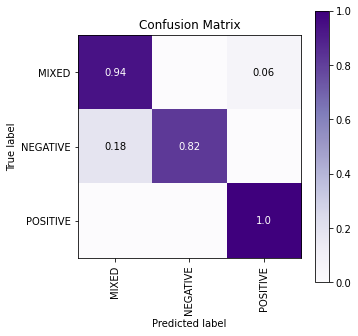

In [ ]:
skplt.metrics.plot_confusion_matrix([Y_SENTIMENT[i] for i in ytest_true_sentiment],
                                    [Y_SENTIMENT[i] for i in ytest_snorkel_sentiment],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [ ]:
ytest_true_sentiment=to_categorical(ytest_true_sentiment)
ytest_snorkel_sentiment=to_categorical(ytest_snorkel_sentiment)

In [ ]:
result_metrics(ytest_true_sentiment,ytest_snorkel_sentiment)

Macro F1 Score: 0.8989461930351036
Macro Precision Score: 0.8953703703703705
Macro Recall Score: 0.9200779727095516
Micro F1 Score: 0.92
Micro Precision Score: 0.92
Micro Recall Score: 0.92
Hamming Loss: 0.05333333333333334


## Predict the Sentiment label for unlabelled data

In [ ]:
L_unlabelled = applier.apply(unlabelled_data)
unlabelled_data['Snorkel_Sentiment_Labels']=label_model.predict(L=L_unlabelled)

100%|██████████| 13536/13536 [00:37<00:00, 357.82it/s]


In [ ]:
LFAnalysis(L=L_unlabelled, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_positive,0,[1],0.421247,0.0,0.0
lf_negative,1,[0],0.306664,0.0,0.0
lf_mixed,2,[2],0.272089,0.0,0.0


In [ ]:
unlabelled_data['Snorkel_Sentiment_Labels'].replace(1,"POSITIVE",inplace=True)
unlabelled_data['Snorkel_Sentiment_Labels'].replace(0,"NEGATIVE",inplace=True)
unlabelled_data['Snorkel_Sentiment_Labels'].replace(2,"MIXED",inplace=True)

In [ ]:
unlabelled_data['Snorkel_Sentiment_Labels'].head(5)

0    POSITIVE
1    NEGATIVE
2       MIXED
3    POSITIVE
4    NEGATIVE
Name: Snorkel_Sentiment_Labels, dtype: object

In [ ]:
yunlabelled_snorkel_sentiment=le.transform(unlabelled_data['Snorkel_Sentiment_Labels'])
yunlabelled_snorkel_sentiment=to_categorical(yunlabelled_snorkel_sentiment)
yunlabelled_snorkel_sentiment

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
unlabelled_data.head()

,Rating,Review_Text,Snorkel_Aspect_Category,Snorkel_Sentiment_Labels
0,1,great product: the peerless univiersal rolling...,"Price, Quality, Service, Size, Usability",POSITIVE
1,0,no no no: this item will smell for about 2 wee...,Quality,NEGATIVE
2,0,locking gas cap: i ordered a locking gas cap a...,"Service, Size, Usability",MIXED
3,1,can't live without it: frederic fekkai shea bu...,"Quality, Size, Usability",POSITIVE
4,0,don't waste your money.: i'm a fairly intellig...,"Price, Size, Usability",NEGATIVE


### Note:
#### We learnt Aspect Category using aspect terms as weak source in labelling functions
#### We learnt Sentiment labels using sentiment vader library and rating as weak sources

## Apply text pre-processing before building the model

### Check for the null values in the data

In [ ]:
train_tagged_data.isnull().sum()

Rating                      0
Review_Text                 0
Usability                   0
Price                       0
Size                        0
Service                     0
Quality                     0
Aspect_Terms                0
Aspect_Sentiment            0
Aspect_Category             0
Snorkel_Aspect_Category     0
Snorkel_Sentiment_Labels    0
dtype: int64

In [ ]:
test_tagged_data.isnull().sum()

Rating                      0
Review_Text                 0
Usability                   0
Price                       0
Size                        0
Service                     0
Quality                     0
Aspect_Terms                0
Aspect_Sentiment            0
Aspect_Category             0
Snorkel_Aspect_Category     0
Snorkel_Sentiment_Labels    0
dtype: int64

In [ ]:
unlabelled_data.isnull().sum()

Rating                      0
Review_Text                 0
Snorkel_Aspect_Category     0
Snorkel_Sentiment_Labels    0
dtype: int64

### Clean the Review Text

In [ ]:
# Remove digits
for i in range(len(train_tagged_data['Review_Text'])):
    train_tagged_data['Review_Text'][i] = re.sub('\d','0',train_tagged_data['Review_Text'][i])

for i in range(len(test_tagged_data['Review_Text'])):
    test_tagged_data['Review_Text'][i] = re.sub('\d','0',test_tagged_data['Review_Text'][i])

for i in range(len(unlabelled_data['Review_Text'])):
    unlabelled_data['Review_Text'][i] = re.sub('\d','0',unlabelled_data['Review_Text'][i])

# Remove links
for i in range(len(train_tagged_data['Review_Text'])):
    if 'www.' in train_tagged_data['Review_Text'][i] or 'http:' in train_tagged_data['Review_Text'][i] or 'https:' in train_tagged_data['Review_Text'][i] or '.com' in train_tagged_data['Review_Text'][i]:
        train_tagged_data['Review_Text'][i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_tagged_data['Review_Text'][i])

for i in range(len(test_tagged_data['Review_Text'])):
    if 'www.' in test_tagged_data['Review_Text'][i] or 'http:' in test_tagged_data['Review_Text'][i] or 'https:' in test_tagged_data['Review_Text'][i] or '.com' in test_tagged_data['Review_Text'][i]:
        test_tagged_data['Review_Text'][i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_tagged_data['Review_Text'][i])

for i in range(len(unlabelled_data['Review_Text'])):
    if 'www.' in unlabelled_data['Review_Text'][i] or 'http:' in unlabelled_data['Review_Text'][i] or 'https:' in unlabelled_data['Review_Text'][i] or '.com' in unlabelled_data['Review_Text'][i]:
        unlabelled_data['Review_Text'][i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", unlabelled_data['Review_Text'][i])

# Remove Punctuations
for i in range(len(train_tagged_data['Review_Text'])):
    train_tagged_data['Review_Text'][i] = re.sub('[^A-Za-z]+', ' ', train_tagged_data['Review_Text'][i])

for i in range(len(test_tagged_data['Review_Text'])):
    test_tagged_data['Review_Text'][i] = re.sub('[^A-Za-z]+', ' ', test_tagged_data['Review_Text'][i])

for i in range(len(unlabelled_data['Review_Text'])):
    unlabelled_data['Review_Text'][i] = re.sub('[^A-Za-z]+', ' ', unlabelled_data['Review_Text'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/

### Remove stopwords

In [ ]:
stop_words = stopwords.words()

for i in range(len(train_tagged_data['Review_Text'])):
    train_tagged_data['Review_Text'][i] = train_tagged_data['Review_Text'][i].split()
    train_tagged_data['Review_Text'][i] = " ".join([word for word in train_tagged_data['Review_Text'][i] if not word in stop_words])

for i in range(len(test_tagged_data['Review_Text'])):
    test_tagged_data['Review_Text'][i] = test_tagged_data['Review_Text'][i].split()
    test_tagged_data['Review_Text'][i] = " ".join([word for word in test_tagged_data['Review_Text'][i] if not word in stop_words])

for i in range(len(unlabelled_data['Review_Text'])):
    unlabelled_data['Review_Text'][i] = unlabelled_data['Review_Text'][i].split()
    unlabelled_data['Review_Text'][i] = " ".join([word for word in unlabelled_data['Review_Text'][i] if not word in stop_words])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: Se

### Visualize the distribuition of most frequently occuring words

In [ ]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.show()

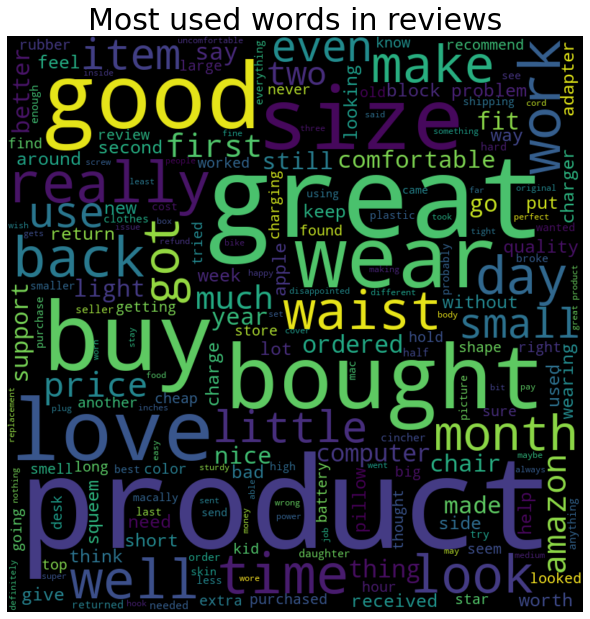

In [ ]:
wordCloud_generator(train_tagged_data['Review_Text'][:10000], title="Most used words in reviews")

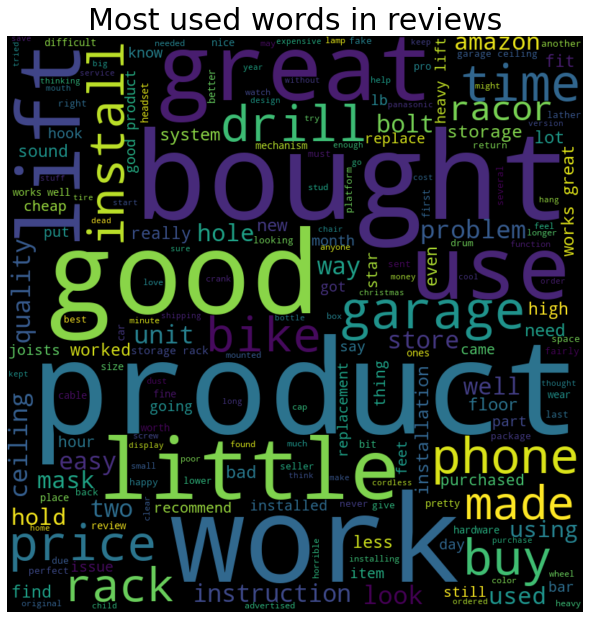

In [ ]:
wordCloud_generator(test_tagged_data['Review_Text'][:10000], title="Most used words in reviews")

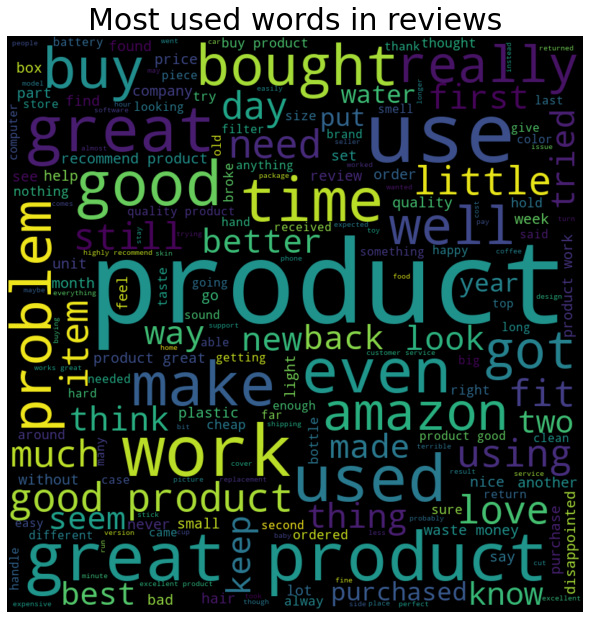

In [ ]:
wordCloud_generator(unlabelled_data['Review_Text'][:10000], title="Most used words in reviews")

### Apply lemmatization

In [ ]:
def clean_text(data):
   le=WordNetLemmatizer()
   word_tokens=word_tokenize(data)
   tokens=[le.lemmatize(w) for w in word_tokens if len(w)>3]
   cleaned_text=" ".join(tokens)
   return cleaned_text

In [ ]:
wnl = WordNetLemmatizer()

train_tagged_data["Review_Text"]=train_tagged_data["Review_Text"].apply(clean_text)

test_tagged_data["Review_Text"]=test_tagged_data["Review_Text"].apply(clean_text)

unlabelled_data["Review_Text"]=unlabelled_data["Review_Text"].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Visualize the distribuition for Rating

In [ ]:
def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [ ]:
class_dist = train_tagged_data['Rating'].value_counts()
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Train data Rating Distribution')

In [ ]:
class_dist = test_tagged_data['Rating'].value_counts()
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Test data Rating Distribution')

In [ ]:
class_dist = unlabelled_data['Rating'].value_counts()
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'unlabelled data Rating Distribution')

### Visualize the distribuition of manually labelled Aspects Usability, Price, Size, Service, Quality

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

train_data_aspect_terms= pd.DataFrame(mlb.fit_transform(train_tagged_data.Aspect_Category.apply(lambda x: [j.strip() for j in x.split(",")])),
                       columns=mlb.classes_,
                       index=train_tagged_data.Aspect_Category.index)

test_data_aspect_terms= pd.DataFrame(mlb.fit_transform(test_tagged_data.Aspect_Category.apply(lambda x: [j.strip() for j in x.split(",")])),
                       columns=mlb.classes_,
                       index=test_tagged_data.Aspect_Category.index)

unlabelled_data_aspect_terms= pd.DataFrame(mlb.fit_transform(unlabelled_data.Snorkel_Aspect_Category.apply(lambda x: [j.strip() for j in x.split(",")])),
                       columns=mlb.classes_,
                       index=unlabelled_data.Snorkel_Aspect_Category.index)

#### Aspect category distribuition of train data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



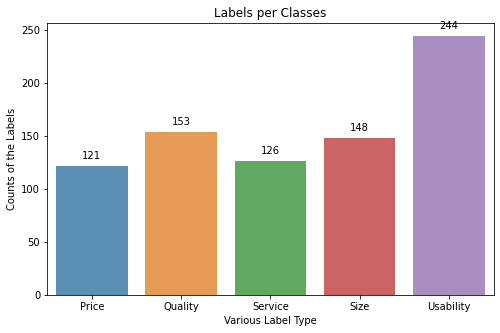

In [ ]:
targets = train_data_aspect_terms[Y_ASPECT_CATEGORY].values
val_counts = train_data_aspect_terms[Y_ASPECT_CATEGORY].sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(val_counts.index, val_counts.values, alpha=0.8)
plt.title("Labels per Classes")
plt.xlabel("Various Label Type")
plt.ylabel("Counts of the Labels")
rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
plt.show()

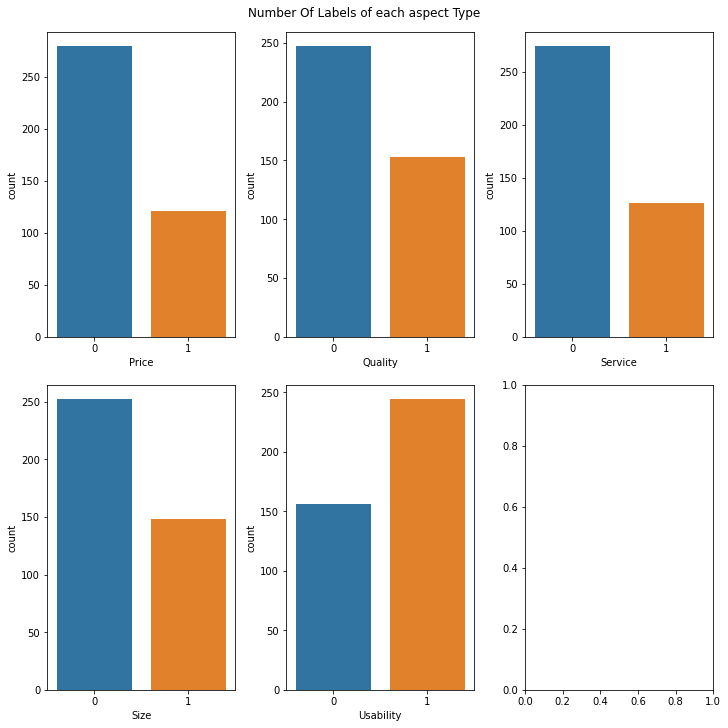

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='Price',data=train_data_aspect_terms )
sns.countplot(ax=axes[0,1],x='Quality',data=train_data_aspect_terms)
sns.countplot(ax=axes[0,2],x='Service',data=train_data_aspect_terms)
sns.countplot(ax = axes[1,0],x='Size',data=train_data_aspect_terms)
sns.countplot(ax=axes[1,1],x='Usability',data=train_data_aspect_terms)
plt.suptitle('Number Of Labels of each aspect Type')
plt.show()

#### Aspect category distribuition of test data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



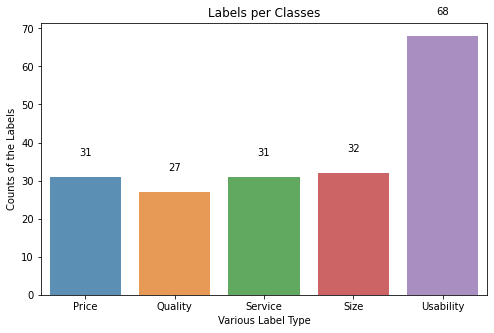

In [ ]:
targets = test_data_aspect_terms[Y_ASPECT_CATEGORY].values
val_counts = test_data_aspect_terms[Y_ASPECT_CATEGORY].sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(val_counts.index, val_counts.values, alpha=0.8)
plt.title("Labels per Classes")
plt.xlabel("Various Label Type")
plt.ylabel("Counts of the Labels")
rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
plt.show()

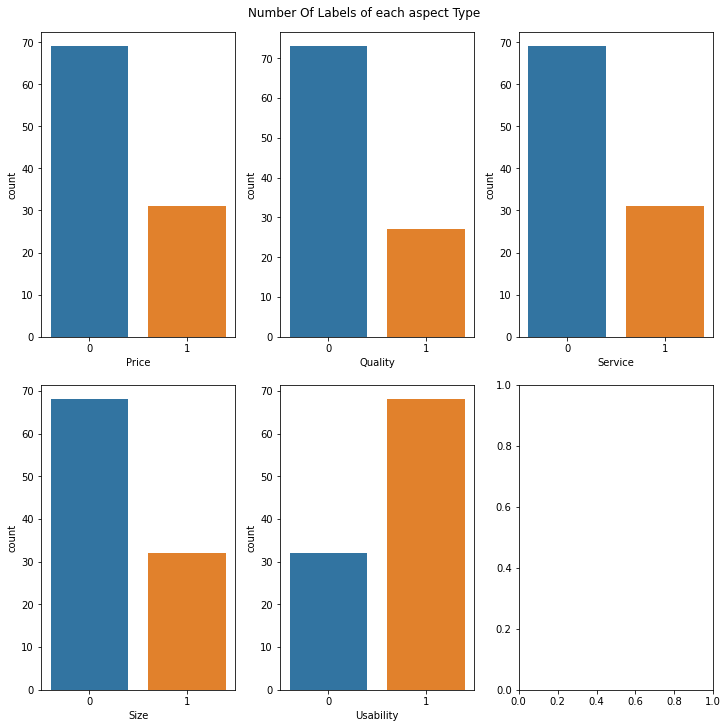

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='Price',data=test_data_aspect_terms )
sns.countplot(ax=axes[0,1],x='Quality',data=test_data_aspect_terms)
sns.countplot(ax=axes[0,2],x='Service',data=test_data_aspect_terms)
sns.countplot(ax = axes[1,0],x='Size',data=test_data_aspect_terms)
sns.countplot(ax=axes[1,1],x='Usability',data=test_data_aspect_terms)
plt.suptitle('Number Of Labels of each aspect Type')
plt.show()

#### Aspect category distribuition of unlabelled data predicted by Snorkel

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



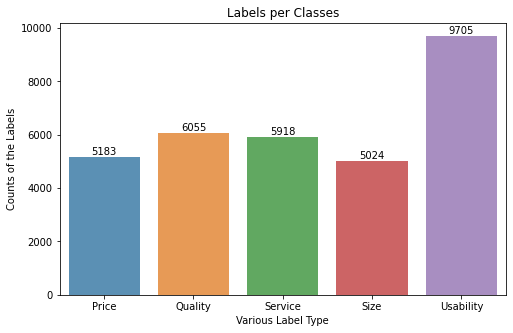

In [ ]:
targets = unlabelled_data_aspect_terms[Y_ASPECT_CATEGORY].values
val_counts = unlabelled_data_aspect_terms[Y_ASPECT_CATEGORY].sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(val_counts.index, val_counts.values, alpha=0.8)
plt.title("Labels per Classes")
plt.xlabel("Various Label Type")
plt.ylabel("Counts of the Labels")
rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
plt.show()

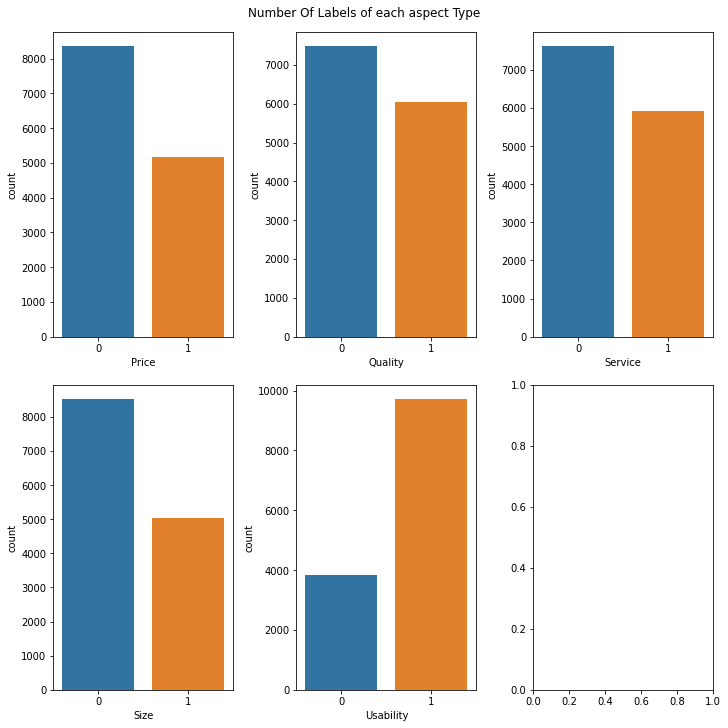

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='Price',data=unlabelled_data_aspect_terms )
sns.countplot(ax=axes[0,1],x='Quality',data=unlabelled_data_aspect_terms)
sns.countplot(ax=axes[0,2],x='Service',data=unlabelled_data_aspect_terms)
sns.countplot(ax = axes[1,0],x='Size',data=unlabelled_data_aspect_terms)
sns.countplot(ax=axes[1,1],x='Usability',data=unlabelled_data_aspect_terms)
plt.suptitle('Number Of Labels of each aspect Type')
plt.show()

### Apply tokenizer on Review Text

In [ ]:
max_len = 500
embed_size = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(unlabelled_data["Review_Text"])

x_train = tokenizer.texts_to_sequences(train_tagged_data["Review_Text"])
x_test= tokenizer.texts_to_sequences(test_tagged_data["Review_Text"])

x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
x_test = pad_sequences(x_test, padding='post', maxlen=max_len)

x_unlabelled = tokenizer.texts_to_sequences(unlabelled_data["Review_Text"])
x_unlabelled = pad_sequences(x_unlabelled, padding='post', maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

### Apply tokenizer on Aspect Terms

In [ ]:
aspect_tokenizer = Tokenizer()
aspect_tokenizer.fit_on_texts(train_tagged_data["Review_Text"])
aspect_tokenized_train = pd.DataFrame(aspect_tokenizer.texts_to_matrix(train_tagged_data["Aspect_Terms"].astype('string')))

aspect_tokenized_test = pd.DataFrame(aspect_tokenizer.texts_to_matrix(test_tagged_data["Aspect_Terms"].astype('string')))
num_words = len(aspect_tokenizer.word_index) + 1

In [ ]:
aspect_terms=usability_aspect_terms+price_aspect_terms+size_aspect_terms+service_aspect_terms+quality_Aspect_terms
aspect_terms_review_main=[]
for i in range(0,len(unlabelled_data["Review_Text"])):
  count=0
  aspect_terms_str=" "
  aspect_terms_review=[]
  for elem in aspect_terms:
    if re.search('\\b'+elem+'\\b',unlabelled_data["Review_Text"][i]):
      aspect_terms_review.append(elem)
      aspect_terms_str=" ".join(aspect_terms_review)
      count+=1
  if count==0:
    aspect_terms_review.append("na")
  aspect_terms_review_main.append(aspect_terms_str)
unlabelled_data["Aspect_Terms"]=aspect_terms_review_main

In [ ]:
aspect_tokenized_unlabelled = pd.DataFrame(aspect_tokenizer.texts_to_matrix(unlabelled_data["Aspect_Terms"].astype('string')))

### Get the rating values

In [ ]:
train_tagged_data['Rating'].replace("POSITIVE",1,inplace=True)
train_tagged_data['Rating'].replace("NEGATIVE",0,inplace=True)
train_rating=train_tagged_data["Rating"].values

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test_rating=test_tagged_data["Rating"].values

In [ ]:
unlabelled_rating=unlabelled_data["Rating"].values

## Use Glove to embed the reviews

In [ ]:
glove_file = open("glove.6B.100d.txt", encoding="utf8")

embedding_vector = {}

for line in tqdm(glove_file):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

vocab_size = len(tokenizer.word_index)+1

embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:15, 25961.40it/s]
100%|██████████| 19449/19449 [00:00<00:00, 469658.69it/s]


## Use Glove to embed the Aspects

In [ ]:
max_len_aspects=50

embedding_matrix_aspects = np.zeros((num_words,100))
for word,i in tqdm(aspect_tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix_aspects[i] = embedding_value

100%|██████████| 2818/2818 [00:00<00:00, 255204.66it/s]


# Hybrid Model

### Bi-LSTM Model

In [ ]:
review_input = Input(shape=(max_len,), name='review_input')
emb = Embedding(output_dim=embed_size, input_dim=vocab_size,weights=[embedding_matrix], input_length=max_len)(review_input)
review_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

rating_input = Input(shape=(1,), name='rating_input')

aspect_input = Input(shape=(num_words,), name='aspect_input')
dense_1=Dense(512, input_shape=(num_words,), activation='relu')(aspect_input)
dense_2=Dense(256, activation='relu')(dense_1)

x = concatenate([review_out,rating_input,dense_2])
x = Dense(64, activation='relu')(x)
aspect_output=Dense(5, activation='sigmoid',name='aspects')(x)
sentiment_output = Dense(3, activation='softmax',name='sentiment')(x)

model = Model(inputs=[review_input,rating_input,aspect_input], outputs=[aspect_output,sentiment_output])

model.compile(loss={'aspects': 'binary_crossentropy', 'sentiment': 'categorical_crossentropy'}, optimizer='adam', metrics='categorical_accuracy')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 review_input (InputLayer)      [(None, 500)]        0           []                               
                                                                                                  
 aspect_input (InputLayer)      [(None, 2819)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     1945000     ['review_input[0][0]']           
                                                                                                  
 dense (Dense)                  (None, 512)          1443840     ['aspect_input[0][0]']           
                                                                                              

In [ ]:
history=model.fit([x_unlabelled,unlabelled_rating,aspect_tokenized_unlabelled],[yunlabelled_snorkel_aspect_category,yunlabelled_snorkel_sentiment],epochs=2, verbose=1)

Epoch 1/2
423/423 [==============================] - 811s 2s/step - loss: 1.2921 - aspects_loss: 0.3791 - sentiment_loss: 0.6086 - aspects_categorical_accuracy: 0.4767 - sentiment_categorical_accuracy: 0.7129
Epoch 2/2
423/423 [==============================] - 811s 2s/step - loss: 0.6414 - aspects_loss: 0.1867 - sentiment_loss: 0.4237 - aspects_categorical_accuracy: 0.5595 - sentiment_categorical_accuracy: 0.8064


In [ ]:
model.save('hybrid_bilstm_model')

INFO:tensorflow:Assets written to: hybrid_bilstm_model/assets


INFO:tensorflow:Assets written to: hybrid_bilstm_model/assets


In [ ]:
model = keras.models.load_model('hybrid_bilstm_model')

In [ ]:
ytest_pred_aspects,ytest_pred_sentiment=model.predict([x_test,test_rating,aspect_tokenized_test])

ytest_pred_aspects[ytest_pred_aspects>=0.5] = 1
ytest_pred_aspects[ytest_pred_aspects<0.5] = 0
print(ytest_pred_aspects[:3])

ytest_pred_sentiment=np.argmax(ytest_pred_sentiment,axis=1)
ytest_pred_sentiment=to_categorical(ytest_pred_sentiment)
print(ytest_pred_sentiment[:3])


[[0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
result_metrics(ytest_true_aspect_category,ytest_pred_aspects)

Macro F1 Score: 0.8162764439775041
Macro Precision Score: 0.7642336099083604
Macro Recall Score: 0.8879295804343244
Micro F1 Score: 0.825
Micro Precision Score: 0.7819905213270142
Micro Recall Score: 0.873015873015873
Hamming Loss: 0.14


In [ ]:
result_metrics(ytest_true_sentiment,ytest_pred_sentiment)

Macro F1 Score: 0.7240693378800795
Macro Precision Score: 0.7803030303030303
Macro Recall Score: 0.7592592592592592
Micro F1 Score: 0.7699999999999999
Micro Precision Score: 0.77
Micro Recall Score: 0.77
Hamming Loss: 0.15333333333333332


### CNN and BI-LSTM model

In [ ]:
review_input = Input(shape=(max_len,), name='review_input')
emb = Embedding(output_dim=embed_size, input_dim=vocab_size,weights=[embedding_matrix], input_length=max_len)(review_input)
review_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

rating_input = Input(shape=(1,), name='rating_input')

aspect_input = Input(shape=(num_words,), name='aspect_input')
emb=Embedding(num_words,embed_size, weights=[embedding_matrix_aspects], input_length=max_len_aspects,trainable = True)(aspect_input)
conv=Conv1D(300, 3, padding='valid', activation='relu', strides=1)(emb)
max_pool=GlobalMaxPool1D()(conv)
dense_1=Dense(128, activation='relu')(max_pool)

x = concatenate([review_out,rating_input,dense_1])
x = Dense(64, activation='relu')(x)
aspect_output=Dense(5, activation='sigmoid',name='aspects')(x)
sentiment_output = Dense(3, activation='softmax',name='sentiment')(x)

model = Model(inputs=[review_input,rating_input,aspect_input], outputs=[aspect_output,sentiment_output])

model.compile(loss={'aspects': 'binary_crossentropy', 'sentiment': 'categorical_crossentropy'}, optimizer='adam', metrics='acc')

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 aspect_input (InputLayer)      [(None, 2819)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 2819, 100)    281900      ['aspect_input[0][0]']           
                                                                                                  
 review_input (InputLayer)      [(None, 500)]        0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2817, 300)    90300       ['embedding_6[0][0]']            
                                                                                            

In [ ]:
history=model.fit([x_unlabelled,unlabelled_rating,aspect_tokenized_unlabelled],[yunlabelled_snorkel_aspect_category,yunlabelled_snorkel_sentiment],epochs=10, verbose=1)

Epoch 1/10
423/423 [==============================] - 1089s 3s/step - loss: 1.0186 - aspects_loss: 0.5512 - sentiment_loss: 0.4149 - aspects_acc: 0.2714 - sentiment_acc: 0.8083
Epoch 2/10
423/423 [==============================] - 1086s 3s/step - loss: 0.8975 - aspects_loss: 0.4914 - sentiment_loss: 0.3565 - aspects_acc: 0.3856 - sentiment_acc: 0.8418
Epoch 3/10
423/423 [==============================] - 1086s 3s/step - loss: 0.7989 - aspects_loss: 0.4314 - sentiment_loss: 0.3113 - aspects_acc: 0.4715 - sentiment_acc: 0.8660
Epoch 4/10
423/423 [==============================] - 1095s 3s/step - loss: 0.6935 - aspects_loss: 0.3697 - sentiment_loss: 0.2632 - aspects_acc: 0.5278 - sentiment_acc: 0.8903
Epoch 5/10
423/423 [==============================] - 1094s 3s/step - loss: 0.5943 - aspects_loss: 0.3031 - sentiment_loss: 0.2218 - aspects_acc: 0.5606 - sentiment_acc: 0.9093
Epoch 6/10
423/423 [==============================] - 1091s 3s/step - loss: 0.4968 - aspects_loss: 0.2303 - sentime

In [ ]:
model.save('hybrid_bilstm_conv_model')

INFO:tensorflow:Assets written to: hybrid_bilstm_conv_model/assets


INFO:tensorflow:Assets written to: hybrid_bilstm_conv_model/assets


In [ ]:
model = keras.models.load_model('hybrid_bilstm_conv_model')

In [ ]:
ytest_pred_aspects,ytest_pred_sentiment=model.predict([x_test,test_rating,aspect_tokenized_test])

ytest_pred_aspects[ytest_pred_aspects>=0.5] = 1
ytest_pred_aspects[ytest_pred_aspects<0.5] = 0
print(ytest_pred_aspects[:3])

ytest_pred_sentiment=np.argmax(ytest_pred_sentiment,axis=1)
ytest_pred_sentiment=to_categorical(ytest_pred_sentiment)
print(ytest_pred_sentiment[:3])


[[0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
result_metrics(ytest_true_aspect_category,ytest_pred_aspects)

Macro F1 Score: 0.7882153850363615
Macro Precision Score: 0.6895361247947454
Macro Recall Score: 0.9267697132616487
Micro F1 Score: 0.8036117381489841
Micro Precision Score: 0.7007874015748031
Micro Recall Score: 0.9417989417989417
Hamming Loss: 0.174


In [ ]:
result_metrics(ytest_true_sentiment,ytest_pred_sentiment)

Macro F1 Score: 0.797350245111439
Macro Precision Score: 0.8029571207304148
Macro Recall Score: 0.8109161793372319
Micro F1 Score: 0.8399999999999999
Micro Precision Score: 0.84
Micro Recall Score: 0.84
Hamming Loss: 0.10666666666666667


### CNN and LSTM model

In [ ]:
review_input = Input(shape=(max_len,), name='review_input')
emb = Embedding(output_dim=embed_size, input_dim=vocab_size,weights=[embedding_matrix], input_length=max_len)(review_input)
review_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

rating_input = Input(shape=(1,), name='rating_input')

aspect_input = Input(shape=(num_words,), name='aspect_input')
emb=Embedding(num_words,embed_size, weights=[embedding_matrix_aspects], input_length=max_len_aspects,trainable = True)(aspect_input)
conv=Conv1D(300, 3, padding='valid', activation='relu', strides=1)(emb)
max_pool=GlobalMaxPool1D()(conv)
dense_1=Dense(128, activation='relu')(max_pool)

x = concatenate([review_out,rating_input,dense_1])
x = Dense(64, activation='relu')(x)
aspect_output=Dense(5, activation='sigmoid',name='aspects')(x)
sentiment_output = Dense(3, activation='softmax',name='sentiment')(x)

model = Model(inputs=[review_input,rating_input,aspect_input], outputs=[aspect_output,sentiment_output])

model.compile(loss={'aspects': 'binary_crossentropy', 'sentiment': 'categorical_crossentropy'}, optimizer='adam', metrics='acc')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 aspect_input (InputLayer)      [(None, 2819)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 2819, 100)    281900      ['aspect_input[0][0]']           
                                                                                                  
 review_input (InputLayer)      [(None, 500)]        0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2817, 300)    90300       ['embedding_1[0][0]']            
                                                                                              

In [ ]:
history=model.fit([x_unlabelled,unlabelled_rating,aspect_tokenized_unlabelled],[yunlabelled_snorkel_aspect_category,yunlabelled_snorkel_sentiment],epochs=10, verbose=1)

In [ ]:
model.save('hybrid_lstm_conv_model')

In [ ]:
model = keras.models.load_model('hybrid_lstm_conv_model')

In [ ]:
ytest_pred_aspects,ytest_pred_sentiment=model.predict([x_test,test_rating,aspect_tokenized_test])

ytest_pred_aspects[ytest_pred_aspects>=0.5] = 1
ytest_pred_aspects[ytest_pred_aspects<0.5] = 0
print(ytest_pred_aspects[:3])

ytest_pred_sentiment=np.argmax(ytest_pred_sentiment,axis=1)
ytest_pred_sentiment=to_categorical(ytest_pred_sentiment)
print(ytest_pred_sentiment[:3])


In [ ]:
result_metrics(ytest_true_aspect_category,ytest_pred_aspects)

In [ ]:
result_metrics(ytest_true_sentiment,ytest_pred_sentiment)